In [18]:
import pandas as pd
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.stats.meta_analysis import combine_effects
from statsmodels.formula.api import ols

In [19]:
# Data extraction

data = pd.read_excel('C:/Users/Alovsat Abdullayev/Desktop/UW/Lessons/Extra year/Reproducible Research\Assginment 10/Data/metaanalysis_data.xlsx')
print(data.head())
print(data.columns)

                       Study  Female authors  Male authors  Age (months)  \
0   Alexander & Saenz (2012)               2             0         19.50   
1              Arthur (2014)               1             0         19.00   
2   Berenbaum & Hines (1992)               2             0         65.79   
3  Berenbaum & Snyder (1995)               2             0         93.10   
4       Doering et al (1989)               1             3         87.00   

   N_boys  N_girls  Mean_boys_play_male  SD_boys_play_male  \
0      47       47               438.72             166.08   
1      22       18               148.00             105.00   
2      18       18               325.25             270.21   
3      19       19               484.21             141.28   
4      15       15               260.10              67.70   

   Mean_girls_play_male  SD_girls_play_male  ...  Country  \
0                248.64              161.28  ...    0.256   
1                 54.00               53.00  ...

**The dataset contains related to studies on children's toy preferences.**

In [20]:
# Calculate effect sizes and standard errors
# Here we are taking differences in mean times and pooling standard deviations as an example
data['EffectSize_boys_male'] = data['Mean_boys_play_male']
data['StdErr_boys_male'] = data['SD_boys_play_male'] / np.sqrt(data['N_boys'])

data['EffectSize_girls_male'] = data['Mean_girls_play_male']
data['StdErr_girls_male'] = data['SD_girls_play_male'] / np.sqrt(data['N_girls'])

data['EffectSize_boys_female'] = data['Mean_boys_play_female']
data['StdErr_boys_female'] = data['SD_boys_play_female'] / np.sqrt(data['N_boys'])

data['EffectSize_girls_female'] = data['Mean_girls_play_female']
data['StdErr_girls_female'] = data['SD_girls_play_female'] / np.sqrt(data['N_girls'])


In [21]:
# Combine the data for meta-analysis
effect_sizes = np.concatenate([data['EffectSize_boys_male'], data['EffectSize_girls_male'],
                               data['EffectSize_boys_female'], data['EffectSize_girls_female']])
std_errors = np.concatenate([data['StdErr_boys_male'], data['StdErr_girls_male'],
                             data['StdErr_boys_female'], data['StdErr_girls_female']])
weights = 1 / std_errors**2

In [22]:
# Fixed effects model
fixed_effects = sm.WLS(effect_sizes, np.ones(len(effect_sizes)), weights=weights).fit()

# Random effects model using DerSimonian-Laird method
variances = std_errors**2
random_effects = combine_effects(effect_sizes, variances, method_re='dl')

print("Fixed Effects Model:\n", fixed_effects.summary())
print("Random Effects Model:\n", random_effects)


Fixed Effects Model:
                             WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.000
Model:                            WLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                       nan
Date:                Sun, 26 May 2024   Prob (F-statistic):                nan
Time:                        21:19:54   Log-Likelihood:                -643.74
No. Observations:                 108   AIC:                             1289.
Df Residuals:                     107   BIC:                             1292.
Df Model:                           0                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         35.5658      4.9

***The fixed effects model shows the average effect size across all studies but does not explain any variability due to no predictors being included. The significant intercept suggests a non-zero average effect size, but the diagnostics indicate potential issues with normality and autocorrelation of residuals.***

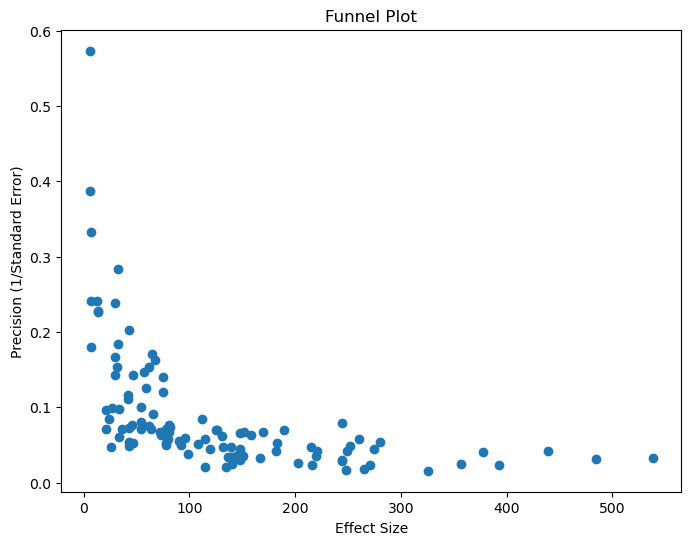

In [24]:
# Funnel plot function
def funnel_plot(effect_sizes, variances):
    precision = 1 / np.sqrt(variances)
    plt.figure(figsize=(8, 6))
    plt.scatter(effect_sizes, precision)
    plt.xlabel('Effect Size')
    plt.ylabel('Precision (1/Standard Error)')
    plt.title('Funnel Plot')
    plt.show()

# Create funnel plot
funnel_plot(effect_sizes, variances)



***This plot suggests that while there may not be a significant publication bias, there is considerable variability in the effect sizes, particularly among smaller studies.***

In [26]:
# Ensure effect_sizes and corresponding data are in the same DataFrame for regression
meta_data = pd.DataFrame({
    'EffectSize': effect_sizes,
    'StdErr': std_errors,
    'NeutralToys': np.tile(data['Neutral toys'], 4),
    'Year': np.tile(data['Year'], 4),
    'ParentPresent': np.tile(data['Parent present'], 4),
    'Setting': np.tile(data['Setting'], 4),
    'Country': np.tile(data['Country'], 4),
    'AuthorGender': np.tile(np.where(data['Female authors'] > data['Male authors'], 'Female', 'Male'), 4)
})

# Meta-regression to check if methods/quality affect the results
meta_regression_model = ols('EffectSize ~ NeutralToys + Year + ParentPresent + Setting + Country', data=meta_data).fit()
print(meta_regression_model.summary())

# Meta-regression to check if author gender affects the results
meta_regression_gender_model = ols('EffectSize ~ AuthorGender', data=meta_data).fit()
print(meta_regression_gender_model.summary())


                            OLS Regression Results                            
Dep. Variable:             EffectSize   R-squared:                       0.168
Model:                            OLS   Adj. R-squared:                  0.126
Method:                 Least Squares   F-statistic:                     3.971
Date:                Sun, 26 May 2024   Prob (F-statistic):            0.00254
Time:                        21:21:49   Log-Likelihood:                -625.53
No. Observations:                 104   AIC:                             1263.
Df Residuals:                      98   BIC:                             1279.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      7080.6039   2685.752      2.636

***The model explains a modest portion of the variability in effect sizes. The year variable is significant, indicating a slight decrease in effect sizes over time. Other variables such as NeutralToys, ParentPresent, Setting, and Country do not significantly contribute to the model. Diagnostics indicate potential issues with non-normality and multicollinearity.***

***The regression model shows that the gender of the authors does not significantly affect the effect sizes in the studies (p = 0.623). The model explains virtually none of the variability in the effect sizes (R-squared = 0.002), and diagnostics indicate issues with non-normality and potential autocorrelation of residuals.***

***The results indicate that while some methodological factors (like the year of the study) might influence effect sizes, the gender of the authors does not. Overall, the models indicate issues with non-normality and potential autocorrelation, suggesting further investigation and possibly more sophisticated modeling approaches might be necessary.***






